## Web Scraping – Day 10 HW (NBA 2025, How do Three Pointers affect a Team's chance to Win?)

#### Web Scraping (static HTML)

- Download the page with `requests`
- Parse with `BeautifulSoup`
- Locate `<table>` elements by `id`
- Convert the table HTML to a DataFrame with `pandas.read_html`

In [53]:
import requests
from bs4 import BeautifulSoup
import requests
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import io

pd.set_option("display.max_columns", 100)

SEASON = 2025
URL = f"https://www.basketball-reference.com/leagues/NBA_{SEASON}.html"

In [54]:
resp = requests.get(URL, headers={"User-Agent": "Mozilla/5.0"})
resp.raise_for_status()
soup = BeautifulSoup(resp.text, "html.parser")
print("Fetched:", URL)


Fetched: https://www.basketball-reference.com/leagues/NBA_2025.html


In [55]:

def read_table_by_id(soup, table_id):
    tbl = soup.find("table", {"id": table_id})
    if tbl is None:
        raise ValueError(f"Table id not found: {table_id}")
    html_str = str(tbl)
    df = pd.read_html(io.StringIO(html_str))[0]
    return df[df.iloc[:, 0] != df.columns[0]].copy()

In [56]:
east_raw = read_table_by_id(soup, "confs_standings_E")
west_raw = read_table_by_id(soup, "confs_standings_W")

east = east_raw.rename(columns={east_raw.columns[0]: "Team"})[["Team","W","L"]].copy()
west = west_raw.rename(columns={west_raw.columns[0]: "Team"})[["Team","W","L"]].copy()

for df in (east, west):
    df["Team"] = df["Team"].str.replace(r"\*", "", regex=True).str.strip()
    df["W"] = pd.to_numeric(df["W"], errors="coerce")
    df["L"] = pd.to_numeric(df["L"], errors="coerce")

standings = (pd.concat([east.assign(Conf="East"), west.assign(Conf="West")], ignore_index=True)
             .dropna(subset=["W","L"])
             .reset_index(drop=True))
standings["Win%"] = standings["W"] / (standings["W"] + standings["L"])
standings.head()

,Team,W,L,Conf,Win%
0,Cleveland Cavaliers,64,18,East,0.780488
1,Boston Celtics,61,21,East,0.743902
2,New York Knicks,51,31,East,0.621951
3,Indiana Pacers,50,32,East,0.609756
4,Milwaukee Bucks,48,34,East,0.585366


In [57]:
per_game_raw = read_table_by_id(soup, "per_game-team")
keep = ["Team","3P","3PA","3P%","PTS","FGA","FG%","AST","TOV","ORB","DRB"]
per_game = per_game_raw[keep].copy()

per_game["Team"] = per_game["Team"].str.replace(r"\*", "", regex=True).str.strip()
for c in [c for c in keep if c != "Team"]:
    per_game[c] = pd.to_numeric(per_game[c], errors="coerce")

per_game.head()

,Team,3P,3PA,3P%,PTS,FGA,FG%,AST,TOV,ORB,DRB
0,Cleveland Cavaliers,15.9,41.5,0.383,121.9,90.8,0.491,28.1,13.2,11.2,34.2
1,Memphis Grizzlies,13.9,37.9,0.367,121.7,93.3,0.479,28.4,15.7,12.9,34.4
2,Denver Nuggets,12.0,31.9,0.376,120.8,89.8,0.506,31.0,14.3,11.2,34.5
3,Oklahoma City Thunder,14.5,38.8,0.374,120.5,92.7,0.482,26.9,11.7,10.6,34.2
4,Atlanta Hawks,13.5,37.7,0.358,118.2,91.8,0.472,29.6,15.5,11.9,32.6


In [58]:
teams = standings.merge(per_game, on="Team", how="inner")
print(teams.shape)
teams.head(10)

(30, 15)


,Team,W,L,Conf,Win%,3P,3PA,3P%,PTS,FGA,FG%,AST,TOV,ORB,DRB
0,Cleveland Cavaliers,64,18,East,0.780488,15.9,41.5,0.383,121.9,90.8,0.491,28.1,13.2,11.2,34.2
1,Boston Celtics,61,21,East,0.743902,17.8,48.2,0.368,116.3,90.0,0.462,26.1,11.9,11.4,33.9
2,New York Knicks,51,31,East,0.621951,12.6,34.1,0.369,115.8,89.2,0.486,27.5,13.3,10.9,31.8
3,Indiana Pacers,50,32,East,0.609756,13.2,35.8,0.368,117.4,89.3,0.488,29.2,13.2,9.2,32.7
4,Milwaukee Bucks,48,34,East,0.585366,14.2,36.6,0.387,115.5,86.4,0.486,25.5,13.4,8.2,35.1
5,Detroit Pistons,44,38,East,0.536585,12.8,35.4,0.362,115.5,89.8,0.476,26.4,14.9,11.4,33.4
6,Orlando Magic,41,41,East,0.500000,11.2,35.3,0.318,105.4,85.8,0.445,23.0,14.2,11.1,30.7
7,Atlanta Hawks,40,42,East,0.487805,13.5,37.7,0.358,118.2,91.8,0.472,29.6,15.5,11.9,32.6
8,Chicago Bulls,39,43,East,0.475610,15.4,42.0,0.367,117.8,92.0,0.470,29.1,14.7,10.1,35.8
9,Miami Heat,37,45,East,0.451220,13.7,37.3,0.367,110.6,87.0,0.465,26.4,13.6,9.7,33.7


### Data Basics and Preparation
- run stats on each of the variables
- count NaNs in each column
- look at the data types
- double-check variable meanings and ranges
- add/use calculated columns (Win%)

In [59]:
teams.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Team    30 non-null     object 
 1   W       30 non-null     int64  
 2   L       30 non-null     int64  
 3   Conf    30 non-null     object 
 4   Win%    30 non-null     float64
 5   3P      30 non-null     float64
 6   3PA     30 non-null     float64
 7   3P%     30 non-null     float64
 8   PTS     30 non-null     float64
 9   FGA     30 non-null     float64
 10  FG%     30 non-null     float64
 11  AST     30 non-null     float64
 12  TOV     30 non-null     float64
 13  ORB     30 non-null     float64
 14  DRB     30 non-null     float64
dtypes: float64(11), int64(2), object(2)
memory usage: 3.6+ KB


In [60]:
teams.isna().sum().sort_values(ascending=False)

Team    0
W       0
L       0
Conf    0
Win%    0
3P      0
3PA     0
3P%     0
PTS     0
FGA     0
FG%     0
AST     0
TOV     0
ORB     0
DRB     0
dtype: int64

### Basic Visualization

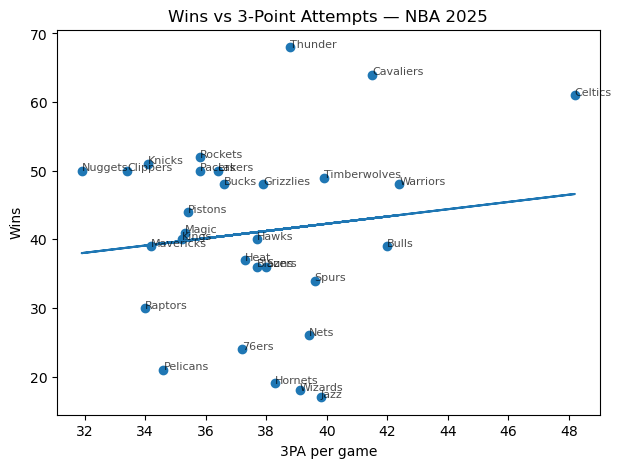

In [61]:
x, y = teams["3PA"], teams["W"]
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(7,5))
plt.scatter(x, y)
plt.plot(x, m*x + b)
for _, r in teams.iterrows():
    plt.annotate(r["Team"].split()[-1], (r["3PA"], r["W"]), fontsize=8, alpha=0.7)
plt.xlabel("3PA per game"); plt.ylabel("Wins")
plt.title(f"Wins vs 3-Point Attempts — NBA {SEASON}")
plt.show()

**Observations**
- This scatter plot shows the relationship between 3 point attempts and wins.
- There is a slight positive trend, as teams that took more 3 pointers tended to win more games, but the relationship is not very strong.
- The Celtics and Thunder both take many threes and are among the top-winning teams, but there are exceptions like the Warriors, who shoot often but have only an average win total.
- The regression line shows a slight positive slope, displaying that although modern teams heavily rely on three point volume, there are many other factors that translate to wins.

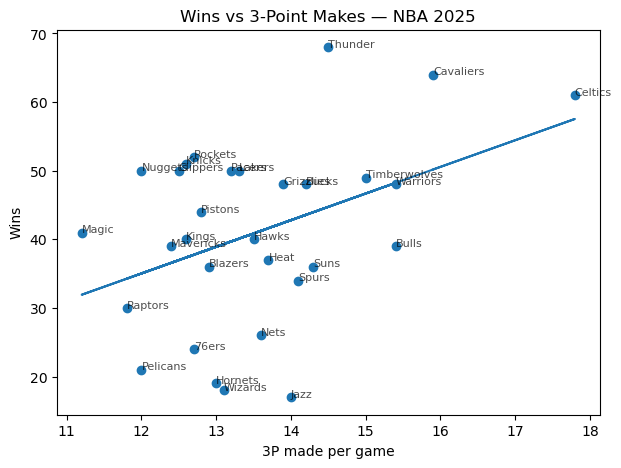

In [62]:
x, y = teams["3P"], teams["W"]
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(7,5))
plt.scatter(x, y); plt.plot(x, m*x + b)
for _, r in teams.iterrows():
    plt.annotate(r["Team"].split()[-1], (r["3P"], r["W"]), fontsize=8, alpha=0.7)
plt.xlabel("3P made per game"); plt.ylabel("Wins")
plt.title(f"Wins vs 3-Point Makes — NBA {SEASON}")
plt.show()

**Observations**
- This plot compares 3 point percentage and number of wins.
- This plot unlike the other one shows a stronger positive relationship, teams that make more threes win more games.
- The regression line has a steeper slope, which means that shooting accuracy is more important than just taking a large number of 3 pointers.
- Teams like the Celtics, Cavaliers, and Thunder combine high 3 point volume with high win totals, while teams with fewer made threes did not win even close to as much.

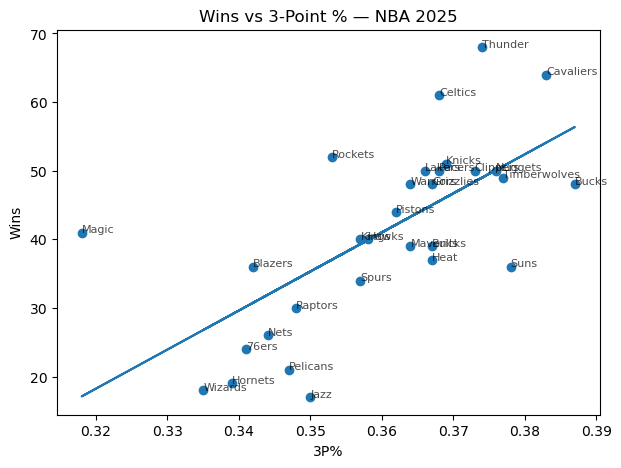

In [63]:
x, y = teams["3P%"], teams["W"]
m, b = np.polyfit(x, y, 1)

plt.figure(figsize=(7,5))
plt.scatter(x, y); plt.plot(x, m*x + b)
for _, r in teams.iterrows():
    plt.annotate(r["Team"].split()[-1], (r["3P%"], r["W"]), fontsize=8, alpha=0.7)
plt.xlabel("3P%"); plt.ylabel("Wins")
plt.title(f"Wins vs 3-Point % — NBA {SEASON}")
plt.show()

**Observations**
- This plot compares 3 point percentage with wins.
- There is a strong correlation between percentage and amount of wins.
- Teams like the Celtics, Cavaliers, and Thunder, which shoot above 37% from three, also have the highest win totals.
- Teams with lower 3P% values, such as the Wizards, Hornets, and Pelicans have fewer wins.
- Taking smarter, higher-quality shots is more valuable than simply increasing attempts.
- The strong upward trend in the regression line highlights that consistent outside shooting is a major factor in modern NBA success.

### Further Exploration

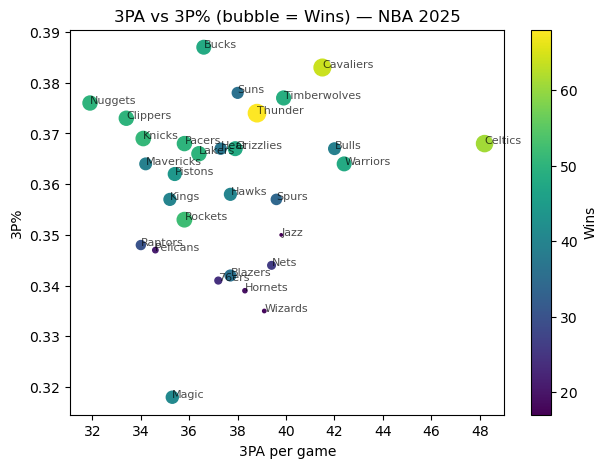

In [67]:
fig, ax = plt.subplots(figsize=(7,5))
sizes = (teams["W"] - teams["W"].min() + 1) * 3
sc = ax.scatter(teams["3PA"], teams["3P%"], s=sizes, c=teams["W"])
for _, r in teams.iterrows():
    ax.annotate(r["Team"].split()[-1], (r["3PA"], r["3P%"]), fontsize=8, alpha=0.7)
ax.set_xlabel("3PA per game"); ax.set_ylabel("3P%")
ax.set_title(f"3PA vs 3P% (bubble = Wins) — NBA {SEASON}")
cb = plt.colorbar(sc); cb.set_label("Wins")
plt.show()

**Observations**
- The x-axis represents 3 point attempts per game
- The y-axis shows 3 point percentage
- The bubble size and color relate to the number of wins.
  
**Overall, this visualization reinforces that both volume and accuracy contribute to success, but efficiency is still more critical for achieving consistent wins.**

### Conclusion

From the data, there is a clear pattern showing that teams who perform well from three-point range tend to have more wins. This means that efficiency matters more than volume, teams need to take smarter shots and convert them at a high rate in order to boost their winning percentage. Just increasing shot quantity will not transalate to wins. Overall, the analysis supports the modern NBA trend where effective 3 point shooting is one of the strongest indicators of a team’s overall performance.